In [3]:
import tqdm
import torch
import torchviz
import numpy as np
import torch.nn.functional as F

from typing import List, Union, Tuple

from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import nn

# Операции с тензорами

Базовые операции с тензорами похожи на NumPy. 

In [4]:
x = torch.tensor(2.0, dtype=torch.float32)
y = torch.tensor([1.0, 2.0, 3.0])
x + y

tensor([3., 4., 5.])

In [5]:
id(x)

140169510042128

In [6]:
x += 2
id(x)

140169510042128

In [7]:
x = torch.ones(2, 2)
y = torch.zeros(2, 2)
x, y

(tensor([[1., 1.],
         [1., 1.]]),
 tensor([[0., 0.],
         [0., 0.]]))

In [8]:
torch.randn(2, 3)

tensor([[-1.2420,  0.5476, -1.1479],
        [ 1.7899,  0.8311,  1.6748]])

In [9]:
torch.randn(2, 3).view((-1, 1))

tensor([[-0.4491],
        [ 0.2375],
        [ 0.0550],
        [ 0.4926],
        [ 0.3278],
        [ 0.1561]])

Важным момент - поддержка CUDA. Существует абстракция `device` - устройство на котором будут произоводиться вычисления

In [10]:
print(torch.cuda.is_available())

cpu = torch.device('cpu')   
# cuda = torch.device('cuda')     
# cuda0 = torch.device('cuda:0')
# cuda1 = torch.device('cuda:1') 
# torch.set_default_tensor_type

x = torch.tensor([1., 2.], device=cpu)
# y = torch.tensor([1., 2.]).cuda()
# z = torch.tensor([1., 2.]).cpu()
# z = torch.tensor([1., 2.]).to(cuda)

# with torch.cuda.device(1):
#     x = torch.tensor([1., 2.], device=cuda)

False


# Автоматическое дифференцировние

Когда при создании тензора указывается параметр `requires_grad`, PyTorch запоминает все операции с тензором, чтобы потом можно было вычислить градиент.

tensor(-2.) tensor(2.)


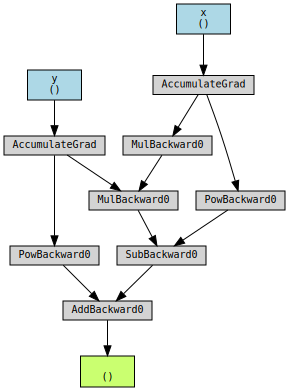

In [11]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

val = x ** 2 - 2 * x * y + y ** 2
val.backward()

print(x.grad, y.grad)

torchviz.make_dot(val, {'x': x, 'y': y})

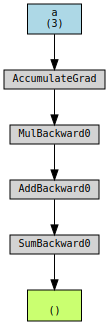

In [12]:
a = torch.tensor([1, 2, 3.], requires_grad=True) 
b = (5 * a + 2).sum()

torchviz.make_dot(b, {'a': a})

# Градиентный спуск

Реализуем наивный градиентный спуск для функции $f(x) = x^2 - 2x + 1$

In [13]:
x = torch.tensor(2., requires_grad=True)
lr = 1e-2

for i in range(500):
    val = x ** 2 - 2 * x + 1
    val.backward()
    
    with torch.no_grad(): 
        x -= lr * x.grad
    
    x.grad.zero_()

print(x)

tensor(1.0000, requires_grad=True)


## Пример решения линейной регрессии

Сгенерируем тренировочное, тестовое и валидационное множества

In [14]:

class DataGen:
    def __init__(self, n: int=3, a: list[int]=[1.2, 3.0, -1.5], b: list[int]=[25]):
        self.n = n
        self.a = np.array(a).reshape((1, -1))
        self.b = np.array(b).reshape((1, -1))

    def gen_Xy(self, count: int=50):
        a, b = self.a, self.b

        noise = np.random.normal(0.0, 1.0, size=(count, 1))
        X = np.random.uniform(-30.0, 30.0, size=(count, self.n))
        y = X @ a.T + self.b + noise

        return X, y

    def gen_Xy_torch(self, count: int =50, device: Union[str, torch.device]="cpu"):
        X, y = self.gen_Xy(count)
        return [torch.tensor(t, dtype=torch.float32, device=device) for t in (X, y)]

In [16]:
n, l, t, v = 3, 300, 50, 10
dg = DataGen(n=n)

X_train, y_train = dg.gen_Xy_torch(l)
X_test, y_test = dg.gen_Xy_torch(t)
X_val, y_val = dg.gen_Xy_torch(t)

In [14]:
X_train[:10], y_train[:10]

(tensor([[ 29.2363,  26.4026,  -9.2761],
         [ -9.4530,  -4.5372, -25.7259],
         [ -6.9291,  -4.4609,  -0.4184],
         [-26.8337, -24.2107,   2.5296],
         [  3.4916, -14.4329,  14.5305],
         [ 13.1509, -16.9585, -28.6664],
         [-29.5296, -12.7419, -20.7630],
         [  3.1683,   1.2716,  -0.6372],
         [-13.0586,  26.2821,  20.1132],
         [ 24.5197,  -5.0746, -27.9367]]),
 tensor([[152.4657],
         [ 38.4594],
         [  3.1569],
         [-83.8929],
         [-35.8083],
         [ 31.7009],
         [-16.7469],
         [ 33.5380],
         [ 57.5005],
         [ 81.1297]]))

## Простой градиентый спуск

In [15]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

learnin_rate = 1e-3
max_epochs = 1000

for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = ((y_train - y_pred) ** 2).mean()
    
    mse.backward()
    with torch.no_grad():
        a -= learnin_rate * a.grad
        b -= learnin_rate * b.grad
        
    a.grad.zero_()
    b.grad.zero_()

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:00<00:00, 2826.58it/s]

tensor([[ 1.2138,  2.9625, -1.5158]], requires_grad=True)
tensor([[21.1998]], requires_grad=True)


## Встроенные оптимизаторы (SGD) и функция потерь (MSELoss)

In [17]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    y_pred = torch.mm(X_train, a.T) + b
    mse = loss(y_train, y_pred)
    
    mse.backward()

    optimizer.step()
    optimizer.zero_grad()    

print(a) 
print(b)    

/home/alex/venvs/venv_nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:00<00:00, 1666.49it/s]

tensor([[ 1.2132,  3.0095, -1.5144]], requires_grad=True)
tensor([[21.6121]], requires_grad=True)


## Батчи

In [17]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()

max_epochs = 1000
batch_size = 30
l = len(X_train)
for epoch in tqdm.trange(max_epochs):
    for batch in range((l + batch_size - 1) // batch_size): 
        s, e = (batch * batch_size), min((batch + 1) * batch_size, l)
        X_batch = X_train[s:e]
        
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_train[s:e], y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b)    

100%|██████████| 1000/1000 [00:03<00:00, 261.73it/s]

tensor([[ 1.1835,  3.0045, -1.4891]], requires_grad=True)
tensor([[25.0187]], requires_grad=True)


## Батчи через Dataset и Dataloader

In [20]:
a = torch.randn((1, n), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

optimizer = SGD([a, b], lr=1e-3)
loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:                
        y_pred = torch.mm(X_batch, a.T) + b
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(a) 
print(b) 

100%|██████████| 1000/1000 [00:07<00:00, 140.70it/s]

tensor([[ 1.1943,  3.0008, -1.5041]], requires_grad=True)
tensor([[25.0913]], requires_grad=True)


# Расширение nn.Module

In [21]:
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self, n: int=3):
        super().__init__()
        self.linear = nn.Linear(n, 1)
                
    def forward(self, x: torch.FloatTensor):        
        return self.linear(x)
    

model = LinearRegression(n)
#model = nn.Sequential(nn.Linear(n, 1))
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 1000
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in data_loader:   
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()    

print(model.state_dict()['linear.weight'])      
print(model.state_dict()['linear.bias']) 

100%|██████████| 1000/1000 [00:07<00:00, 126.88it/s]

tensor([[ 1.1943,  3.0008, -1.5041]])
tensor([25.0913])


## Tensorboard

Запуск в командной строке:

```tensorboard --logdir .```

In [23]:
writer = SummaryWriter()

model = LinearRegression(n)
optimizer = SGD(model.parameters(), lr=1e-3)

loss = MSELoss()
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset, batch_size=30)

max_epochs = 100
for epoch in tqdm.trange(max_epochs):
    for X_batch, y_batch in train_loader:
        model.train()
        y_pred = model(X_batch)
        mse = loss(y_batch, y_pred)

        mse.backward()

        optimizer.step()
        optimizer.zero_grad()

    if epoch % 3 == 0:
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            mse_val = loss(y_val, y_pred)

            stat = {"mse_validation": mse_val.item(), "b": model.state_dict()["linear.bias"]}
            writer.add_graph(model, X_val)
            writer.add_scalars("training/stat", stat, epoch)
            torch.save(model, "checkpoint")

writer.close()

print(model.state_dict()["linear.weight"])
print(model.state_dict()["linear.bias"])

100%|██████████| 100/100 [00:02<00:00, 43.36it/s]

tensor([[ 1.1899,  3.0140, -1.5214]])
tensor([21.6178])


## Использование Lighting

In [22]:
import lightning as pl


class PyLightingModel(pl.LightningModule):    
    def __init__(self, n: int=3):
        super().__init__()
        
        self.model = LinearRegression(n)
    
    def forward(self, x: torch.FloatTensor):
        return self.model(x)
    
    def validation_step(self, batch: Tuple[torch.FloatTensor, torch.FloatTensor], batch_idx: int):
        x, y = batch

        loss = F.mse_loss(self(x), y)

        self.log("eval/loss", loss)

        return loss        
    
    def training_step(self, batch: Tuple[torch.FloatTensor, torch.FloatTensor], batch_idx: int):
        x, y = batch

        loss = F.mse_loss(self(x), y)

        self.log("train/loss", loss)

        return loss         

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-1)
        return optimizer
    

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset, batch_size=30, num_workers=3)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(dataset=dataset, batch_size=10, num_workers=3)

pl_model = PyLightingModel()

trainer = pl.Trainer(max_epochs=20, log_every_n_steps=5)
trainer.fit(pl_model, train_loader, val_loader)   

print(pl_model.state_dict()["model.linear.weight"])
print(pl_model.state_dict()["model.linear.bias"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | LinearRegression | 4      | train
---------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 17.38it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s, v_num=0]
tensor([[ 1.1656,  2.9913, -1.5521]])
tensor([15.4805])


## Использование Transformers Trainer

In [23]:
from transformers import Trainer, TrainingArguments
from datasets import Dataset

train_dataset = Dataset.from_dict({"x": X_train, "y": y_train})
eval_dataset = Dataset.from_dict({"x": X_val, "y": y_val})

class CustomTrainer(Trainer):
    def compute_loss(self, model: torch.nn.Module, inputs, return_outputs: bool=False):
        x = inputs.pop("x")
        outputs = model(x)

        target = inputs.get("y")
        loss = F.mse_loss(outputs, target)

        return (loss, outputs) if return_outputs else loss
    
args = TrainingArguments(
    "training-run",
    num_train_epochs=100,
    learning_rate=1e-1, 
    report_to="tensorboard",
    label_names=["y"],
    per_device_train_batch_size=30,
    per_device_eval_batch_size=5
)

trainer = CustomTrainer(
    model, 
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

print(model.state_dict()["linear.weight"])
print(model.state_dict()["linear.bias"])

 54%|█████▍    | 542/1000 [00:01<00:01, 283.06it/s]

{'loss': 1.398, 'grad_norm': 17.411731719970703, 'learning_rate': 0.05, 'epoch': 50.0}


100%|██████████| 1000/1000 [00:03<00:00, 289.68it/s]

{'loss': 1.1205, 'grad_norm': 6.538822650909424, 'learning_rate': 0.0, 'epoch': 100.0}
{'train_runtime': 3.4446, 'train_samples_per_second': 8709.322, 'train_steps_per_second': 290.311, 'train_loss': 1.2592613525390626, 'epoch': 100.0}
tensor([[ 1.2003,  2.9999, -1.5012]])
tensor([25.0773])
